<a href="https://colab.research.google.com/github/wmezadev/CSE-450-TEAM-4/blob/emoreiravirtus-patch-1/module-5/Signs_module_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Initial setup

TODO: We need to merge training2.zip with training1.zip, by now, all the script is using only training1.zip

In [9]:
import pathlib
import urllib.request
import zipfile
import os

# URLs for the datasets
dataset_url_1 = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/roadsigns/training1.zip"
dataset_url_2 = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/roadsigns/training2.zip"

# Download the ZIP files
zip_file_1, _ = urllib.request.urlretrieve(dataset_url_1)
zip_file_2, _ = urllib.request.urlretrieve(dataset_url_2)

# Extract the contents of training1.zip
with zipfile.ZipFile(zip_file_1, 'r') as zip_ref:
    zip_ref.extractall()

# Extract the contents of training2.zip and merge with training1
with zipfile.ZipFile(zip_file_2, 'r') as zip_ref:
    zip_ref.extractall()

# Remove the ZIP files
os.remove(zip_file_1)
os.remove(zip_file_2)

# Path to the merged dataset directory
data_dir = pathlib.Path("training1")

# our learning rates/sizes
batch_size = 32
img_height = 100
img_width = 100

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)



26970


Creates the train, and validation sets

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26970 files belonging to 21 classes.
Using 21576 files for training.
Found 26970 files belonging to 21 classes.
Using 5394 files for validation.


Print some images so we have an idea of what we are working with

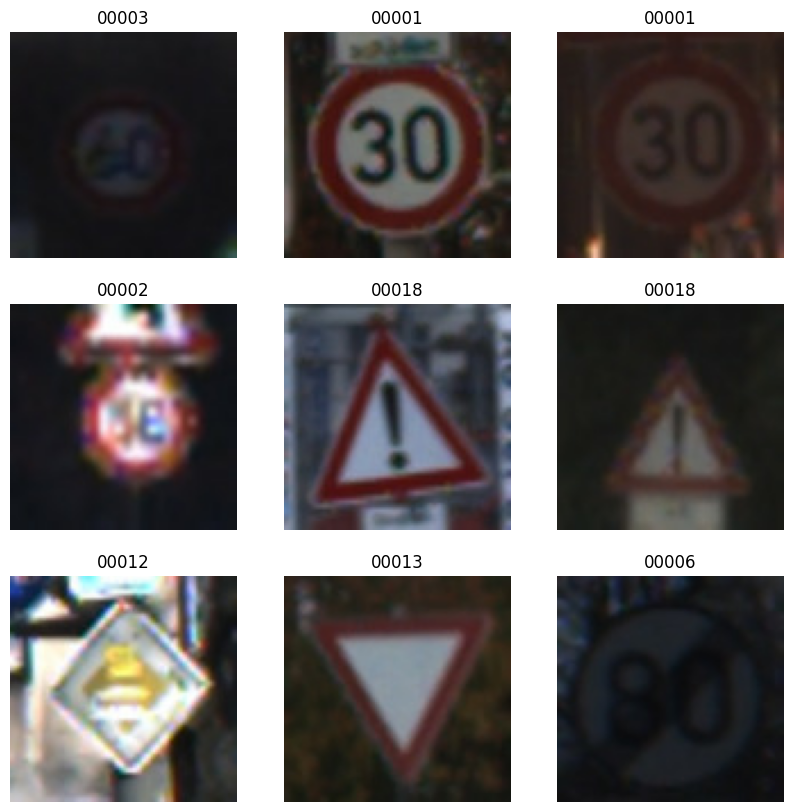

In [11]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

This part is just for performance improvement

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Actual Model

In [13]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
675/675 [==============================] - 25s 14ms/step - loss: 1.3630 - accuracy: 0.5654 - val_loss: 0.5701 - val_accuracy: 0.8296
Epoch 2/15
675/675 [==============================] - 7s 10ms/step - loss: 0.4908 - accuracy: 0.8426 - val_loss: 0.2344 - val_accuracy: 0.9308
Epoch 3/15
675/675 [==============================] - 8s 12ms/step - loss: 0.2978 - accuracy: 0.9071 - val_loss: 0.1673 - val_accuracy: 0.9520
Epoch 4/15
675/675 [==============================] - 7s 11ms/step - loss: 0.2413 - accuracy: 0.9249 - val_loss: 0.1149 - val_accuracy: 0.9663
Epoch 5/15
675/675 [==============================] - 7s 11ms/step - loss: 0.1906 - accuracy: 0.9407 - val_loss: 0.1161 - val_accuracy: 0.9685
Epoch 6/15
675/675 [==============================] - 8s 11ms/step - loss: 0.1686 - accuracy: 0.9472 - val_loss: 0.1018 - val_accuracy: 0.9705
Epoch 7/15
675/675 [==============================] - 7s 11ms/step - loss: 0.1488 - accuracy: 0.9531 - val_loss: 0.0784 - val_accuracy: 0.978

Visual Results

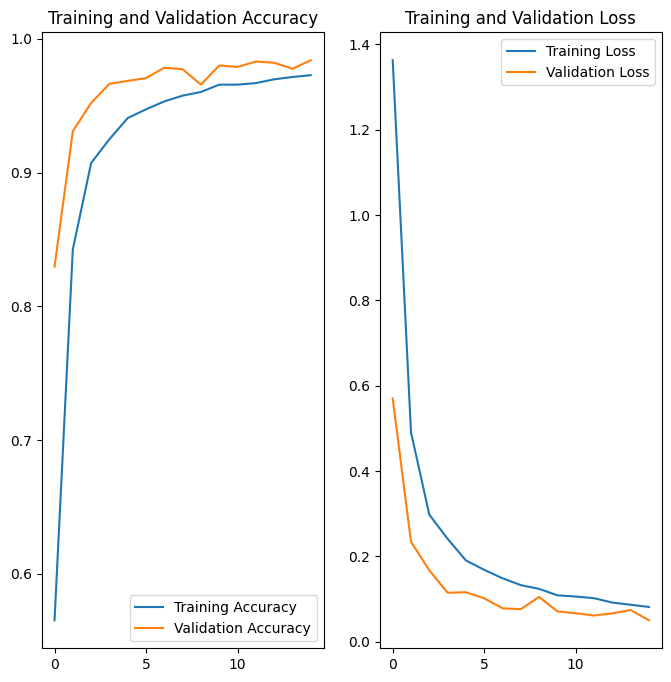

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing the model
Once you have built and trained your model, the next step is to run the test images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.



```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Partial Hold out Dataset
You're given the answers to the first 200 images in the hold out dataset.

Once you have predictions for the partial holdout dataset, you'll need to compare those predictions against the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.

Make sure to use the insights gained from the partial hold out dataset in your executive summary.

Once you feel confident, you will need to predict for the full test dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```